# Clase 13 - Regresión y ajuste de modelos

Basada en https://emcee.readthedocs.io/en/stable/tutorials/line/

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
plt.style.use('seaborn-poster')

### Ajuste de mínimos cuadrados

Generemos un conjunto de datos con una distribución aleatoria en torno a $y=b+mx$ con $m=-0.9594$ y $b=4.294$.

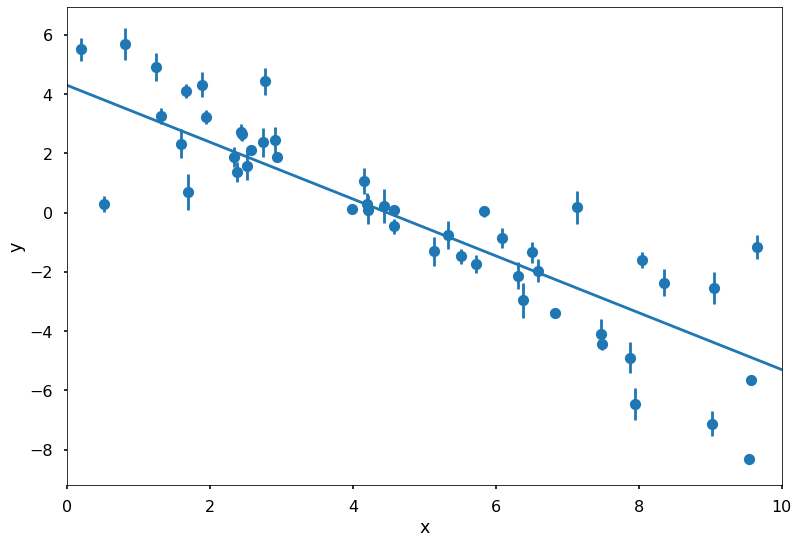

In [3]:
m_true = -0.9594
b_true = 4.294
f_true = 0.534 # f es incluida para generar datos con incertezas subestimadas en un factor constante
               # si f=0 se tiene un problema de mínimos cuadrados estándar
N = 50
np.random.seed(8237)
x = np.sort(10*np.random.rand(N))
yerr = 0.1 + 0.5*np.random.rand(N)
y = m_true*x + b_true
y += np.abs(f_true*y)*np.random.randn(N)
y += yerr*np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt="o")
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true*x0 + b_true, 'C0')
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

Definamos los vectores y matrices (ver https://arxiv.org/abs/1008.4686)
\begin{equation*}
\begin{array}{c}
\mathbf{Y}=\left[\begin{array}{c}y_{1} \\ y_{2} \\ \dots \\ y_{N}\end{array}\right] \qquad \mathbf{M}=\left[\begin{array}{cccc}1 & x_{1} \\ 1 & x_{2} \\ \dots &\ldots \\ 1 & x_{N}\end{array}\right] \qquad \mathbf{C}=\left[\begin{array}{cccc}\sigma_{y 1}^{2} & 0 & \cdots & 0 \\ 0 & \sigma_{y 2}^{2} & \cdots & 0 \\ & & \cdots \\ 0 & 0 & \cdots & \sigma_{y N}^{2}\end{array}\right]\end{array}
\end{equation*}

Los valores del mejor ajuste están dados por

\begin{equation*}
\left[\begin{array}{l} b \\ m \end{array}\right]=\mathbf{X}=\left[\mathbf{M}^{\top} \mathbf{C}^{-1} \mathbf{M}\right]^{-1}\left[\mathbf{M}^{\top} \mathbf{C}^{-1} \mathbf{Y}\right]
\end{equation*}

donde $\mathbf{X}$ minimiza la función objetivo

\begin{equation*}
\chi^{2}=\sum_{i=1}^{N} \frac{\left[y_{i}-f\left(x_{i}\right)\right]^{2}}{\sigma_{y i}^{2}} \equiv[\mathbf{Y}-\mathbf{MX}]^{\top} \mathbf{C}^{-1}[\mathbf{Y}-\mathbf{M X}]
\end{equation*}

La incerteza de los coeficientes de ajuste están dados por la matrix covarianza $\left[\mathbf{M}^{T} \mathbf{C}^{-1} \mathbf{M}\right]^{-1}$.

In [4]:
A = np.vander(x,2)
C = np.diag(yerr * yerr)
Cinv = np.linalg.inv(C)
cov = np.linalg.inv(np.dot(np.dot(A.T,Cinv),A))
w = np.dot(cov,np.dot(np.dot(A.T,Cinv),y))
print("Parámetros de ajuste con estimación de error:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

Parámetros de ajuste con estimación de error:
m = -1.196 ± 0.014
b = 5.239 ± 0.080


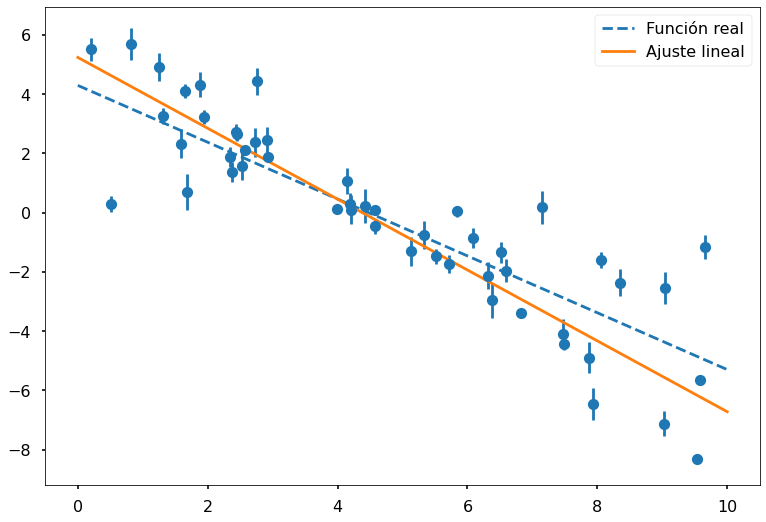

In [5]:
xp = np.linspace(0,10,200)
y2 = w[0]*xp + w[1]
y1 = m_true*xp + b_true
plt.errorbar(x,y,yerr=yerr,fmt="o")
plt.plot(xp,y1,'C0--',label='Función real')
plt.plot(xp,y2,label='Ajuste lineal')
plt.legend();

### Maximum Likelihood Estimation (MLE)

La solución de mínimos cuadrados es el resultado MLE para un modelo donde las barras de error son asumidas correctas, Gaussianas e independientes. Este no es el caso y por lo tanto debemos usar la función de verosimilitud dada por

\begin{equation*}
\ln p(y \mid x, \sigma, m, b, f)=-\frac{1}{2} \sum_{n}\left[\frac{\left(y_{n}-m x_{n}-b\right)^{2}}{s_{n}^{2}}+\ln \left(2 \pi s_{n}^{2}\right)\right]
\end{equation*}

donde 

\begin{equation*}
s_{n}^{2}=\sigma_{n}^{2}+f^{2}\left(m x_{n}+b\right)^{2}
\end{equation*}

In [6]:
from scipy.optimize import minimize

In [7]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m*x + b
    sigma2 = yerr**2 + model**2*np.exp(2*log_f)
    return -0.5*np.sum((y - model)**2/sigma2 + np.log(2.0*np.pi*sigma2))

In [8]:
np.random.seed(42)
nll = lambda *args: -log_likelihood(*args) # buscamos el MLE minimizando -log-likelihood

initial = np.array([m_true, b_true, np.log(f_true)]) + 0.5*np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

Maximum likelihood estimates:
m = -1.083
b = 4.892
f = 0.482


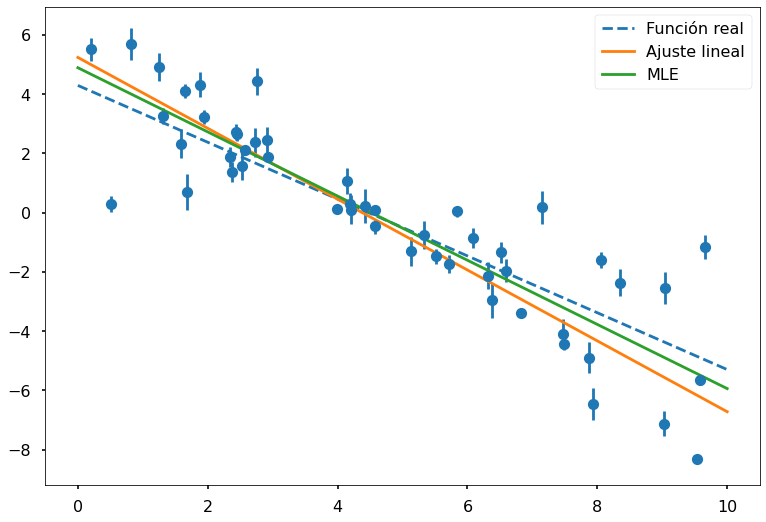

In [9]:
y3 = b_ml + m_ml*xp
plt.errorbar(x,y,yerr=yerr,fmt="o")
plt.plot(xp,y1,'C0--',label='Función real')
plt.plot(xp,y2,label='Ajuste lineal')
plt.plot(xp,y3,label='MLE')
plt.legend();

### Marginalización y estimación de incertezas

La función de probabilidad posterior es

\begin{equation*}
p(m, b, f \mid x, y, \sigma) \propto p(m, b, f) \; p(y \mid x, \sigma, m, b, f)
\end{equation*}

donde $p(y \mid x, \sigma, m, b, f)$ es la función de verosimilitud y $p(m, b, f)$ es la probabilidad previa que contiene todo el conocimiento que tenemos de los paramétros del modelo.

Definamos una probabilidad previa uniforme (no-informativa) sobre los paramétros $m$, $b$ y $\ln f$.

In [10]:
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

Entonces el logaritmo de la probabilidad está dado por

$$
\log p(m, b, f \mid x, y, \sigma) = \log p(m, b, f) + \log p(y \mid x, \sigma, m, b, f)
$$

In [11]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

Usemos el método de Monte Carlo Markov Chain para explorar el espacio de paramétros en torno al valor MLE (ver https://arxiv.org/abs/1202.3665)

In [12]:
import emcee

pos = soln.x + 1e-2*np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:06<00:00, 714.95it/s]


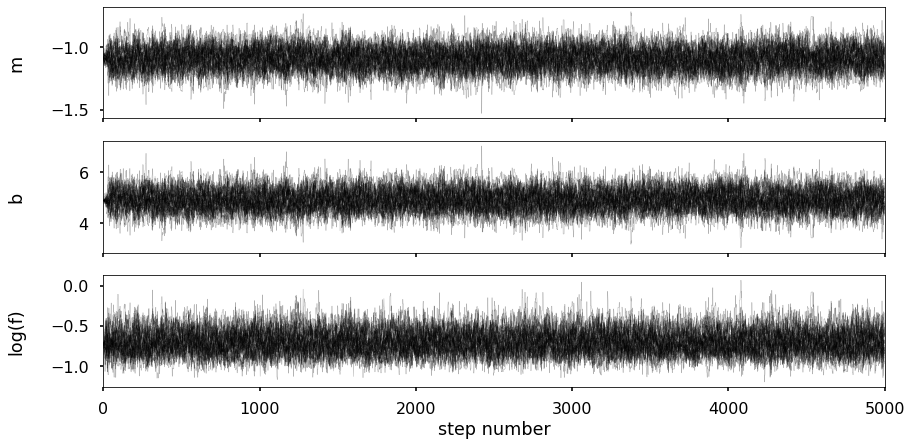

In [13]:
fig, axes = plt.subplots(3, figsize=(14, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3, lw=0.5)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [14]:
tau = sampler.get_autocorr_time()
print(tau)

[39.89954093 40.52865597 38.47848169]


In [15]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 3)


In [16]:
import corner

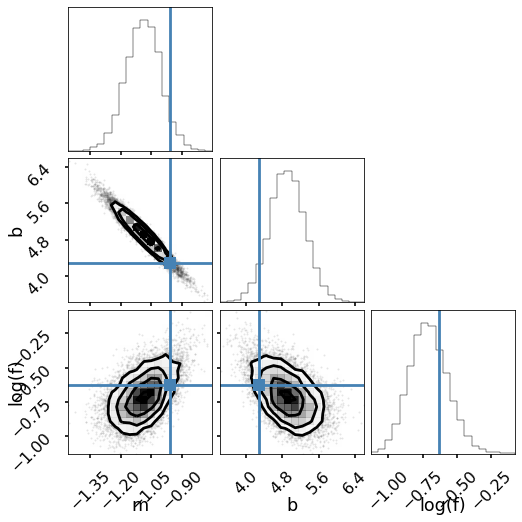

In [17]:
fig = corner.corner(flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)])

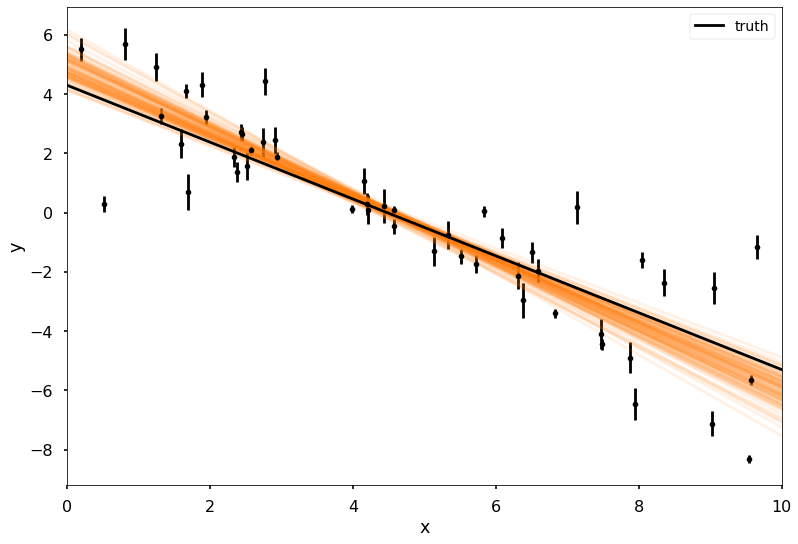

In [18]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(xp, np.dot(np.vander(xp, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(xp, m_true * xp + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [19]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>